In [1]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

In [2]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [3]:
# ylabel_name = 'marions_ylabels_esd_removed'
ylabel_name = 'marions_ylabels'
data_features = pd.read_csv("data/optimal_features.csv")
clustering_features = plotting.extract_numerical_features(data_features)

In [4]:
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
cluster_num_to_ylabel = {v: k for k, v in ylabel_to_cluster_num.items()}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

In [5]:
def loss(pseudo_labels:pd.Series, actual_labels:pd.Series):
    pseudo_actual_intersection = pseudo_labels.loc[actual_labels.index]
    diff_mask = pseudo_actual_intersection != actual_labels
    diff_labels = pseudo_actual_intersection[diff_mask]
    return diff_labels.index
    
def correct_pseudo_ylabels_to_actual(pseudo_labels:pd.Series, actual_labels:pd.Series, changed_ylabel_idxs) -> pd.Series:
    corrected_pseudo_labels = pseudo_labels.copy()
    corrected_pseudo_labels.loc[changed_ylabel_idxs] = actual_labels
    return corrected_pseudo_labels

# Split Based on Popcorn

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestCentroid was fitted without feature names
  warnings.warn(


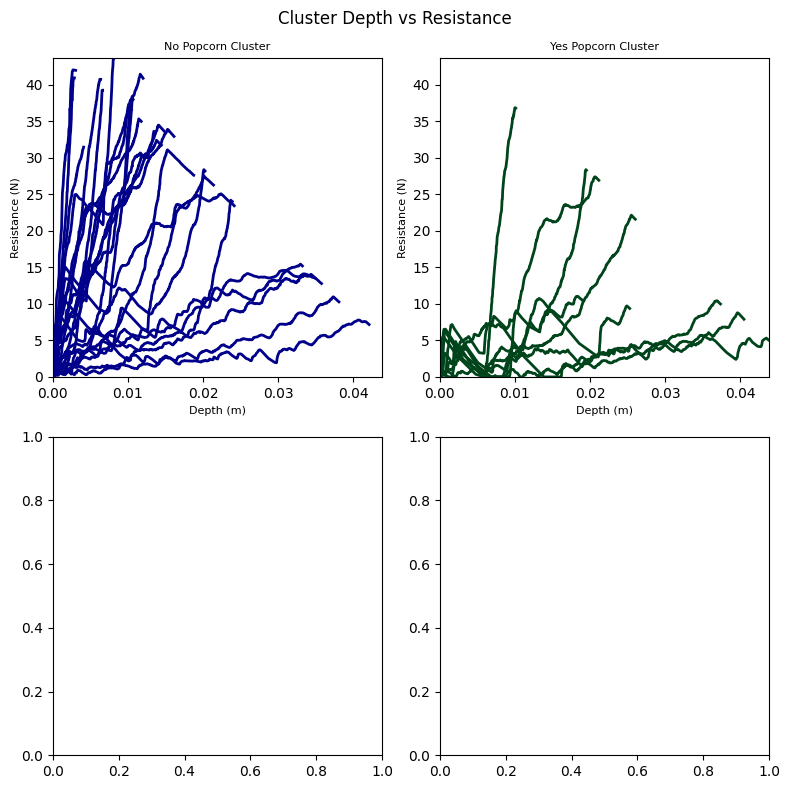

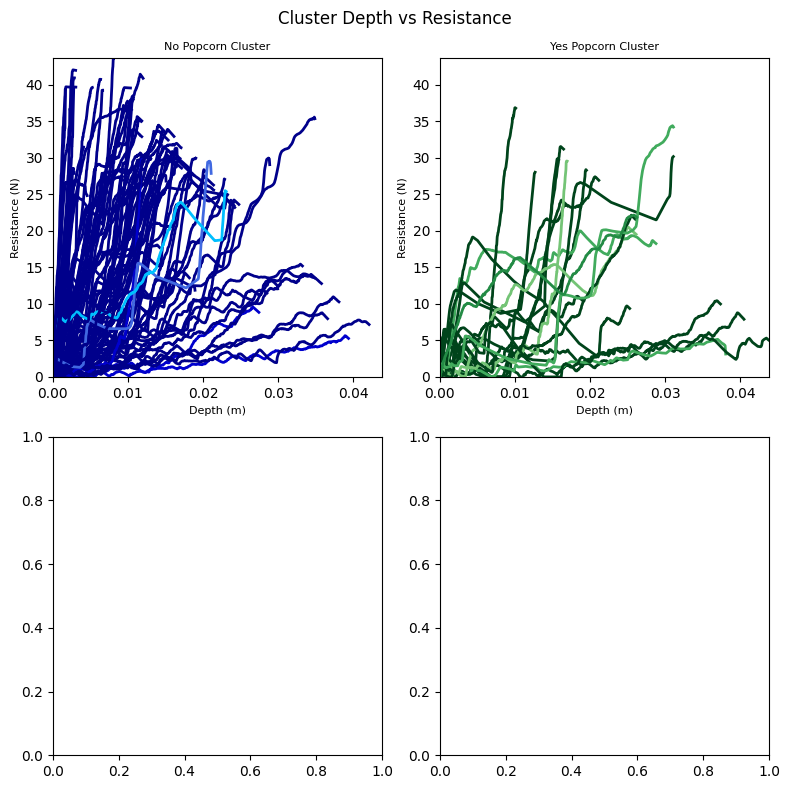

In [6]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "popcorn"
data_with_popcorn_label = data_features[data_features['popcorn'].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label['popcorn'].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')

# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data, 
                            cluster_category_names=["No Popcorn", "Yes Popcorn"], 
                            bold_idxs=popcorn_ylabels.index,
                            prediction_proba=proba)
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, centroids=centroids)

# plotting labeled with predictions
plotting.plot_cluster_subplots(
                            corrected_predctions,
                            curve_data,
                            cluster_category_names=["No Popcorn", "Yes Popcorn"],
                            bold_idxs=popcorn_ylabels.index,
                            prediction_proba=proba)
plotting.plot_pca(clustering_features, corrected_predctions, 3, "", ylabel_name=ylabel_name, centroids=centroids)
